In [47]:
import torch
import os
from model_training import MultiTaskColorModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_folder = 'models'
model_name = 'ResNet50_50_0.1_0.9_v2.pth'
# model_name = 'ResNet50_50_0.1_0.9.pth'
# model_name = '100_0.1_1.0_color_model.pth'
model_path = os.path.join(model_folder, model_name)
# model_path = 'Normalized_100_1.0_1.0_color_model.pth'
# model_name = '100_0.1_1.0_color_model.pth'
# model_path = '50_1.0_1.0_color_model.pth'
# model_path = '50_0.0_1.0_color_model.pth'
# model_path = 'ResNet_152_50_0.1_1.0.pth'
# model_path = 'ResNet_152_50_0.1_1.0_v2.pth';
model = MultiTaskColorModel(num_classes=8, regression_output_size=4)
# model = torch.load('100_0.1_color_model.pth', weights_only=False)
model.load_state_dict(torch.load(model_path, weights_only=True))
print('Model loaded from {}'.format(model_path))

model = model.to(device)

model.eval()
total_correct = 0
total_samples = 0
total_reg_loss = 0.0


C:\Users\zjr02\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\zjr02\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded from models\ResNet50_50_0.1_0.9_v2.pth


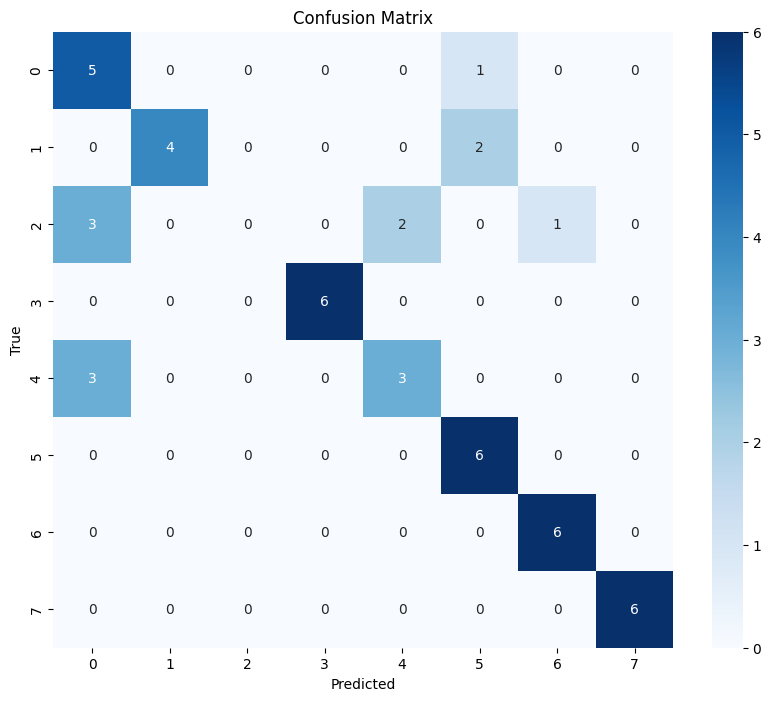

[(0, 'P460-3M'), (1, 'P470-3U'), (2, 'P470-4M'), (3, 'P480-3U'), (4, 'P480-4M'), (5, 'P490-3U'), (6, 'P490-4M'), (7, 'P490-5M')]
Total samples: 48
Validation Accuracy: 75.00%
Average Regression Loss: 34.2389


In [ ]:
from model_training import ColorDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

csv_file = r'D:\COSI149\color_with_label\label.csv'
img_dir = r'D:\COSI149\color_with_label'
original_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # if trainning data was normalized, then test data should also be normalized
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ColorDataset(csv_file=csv_file, img_dir=img_dir, transform=original_transform)
dataloader = DataLoader(dataset, batch_size=48, shuffle=True)

criterion_class = nn.CrossEntropyLoss()
criterion_reg = nn.MSELoss()

with torch.no_grad():
    all_labels = []
    all_predicted = []
    encoded_mapping = {}
    
    for images, labels, color_codes, encoded_labels in dataloader:
        images = images.to(device)
        encoded_labels = encoded_labels.to(device)
        color_codes = color_codes.to(device)

        class_outputs, reg_outputs = model(images)

        encoded_mapping = {encoded_label : label for encoded_label, label in zip(encoded_labels.tolist(), labels)}
        encoded_mapping = sorted(encoded_mapping.items(), key=lambda x: x[0])
        # Classifacation accuracy
        _, predicted = torch.max(class_outputs, 1)
        total_samples += encoded_labels.size(0)
        total_correct += (predicted == encoded_labels).sum().item()
        # print(f"predicted: {predicted.tolist()}\n labels: {labels.tolist()}\n")
        all_labels += encoded_labels.tolist()
        all_predicted += predicted.tolist()

        # Regression loss
        loss_reg = criterion_reg(reg_outputs, color_codes)
        total_reg_loss += loss_reg.item()

    # show the confusion matrix


    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predicted)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(encoded_mapping)

    print(f"Total samples: {total_samples}")
    accuracy = total_correct / total_samples
    avg_reg_loss = total_reg_loss / len(dataloader)
    print(f"Validation Accuracy: {accuracy*100:.2f}%")
    print(f"Average Regression Loss: {avg_reg_loss:.4f}")


# record the model's performance with timestamp
import datetime

with open('model_performance.txt', 'a') as f:
    f.write(f"{datetime.datetime.now()}\n")
    f.write(f"Model: {model_path}\n")
    f.write(f"Validation Accuracy: {accuracy*100:.2f}%\n\n")
    